In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, random_split, ChainDataset
import torch.optim as optim
import matplotlib.pyplot as plt 
import torch.nn.functional as F


In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv3d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout3d()
        self.fc1 = nn.Linear(540, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(F.max_pool3d(self.conv1(x), 2))
        x = F.relu(F.max_pool3d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 540)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [4]:
realImages = np.load("originalSubsets.npy")
realImages.shape

(1967, 20, 20, 20)

In [5]:
fakeImages = np.load("rescaledSubsets.npy")
fakeImages.shape

(1967, 20, 20, 20)

In [6]:
import random
random.shuffle(realImages)
random.shuffle(fakeImages)
data = []
for realImage in realImages[:1477]:
    data.append((realImage,0.))

for fakeImage in fakeImages[:1477]:
    data.append((fakeImage, 1.))

In [7]:
data = DataLoader(data, shuffle=True)

In [8]:
n_epochs = 3
learning_rate = 0.001
momentum = 0.5



In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
x = []
y = []
for epoch in range(1, 20):
    train_loss = 0
    for batch_idx, (img, target) in enumerate(data):
        img, target = img.unsqueeze(0).float().to(device), target.long().to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = F.nll_loss(output, target)
        loss.backward()
        train_loss+=loss.item()
        optimizer.step()
        
    x.append(epoch)
    y.append(train_loss)


<ipython-input-3-5341c141cdcd>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


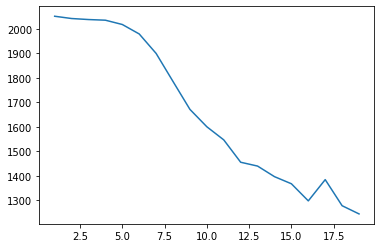

In [11]:
plt.plot(x, y)

In [12]:
testData = []
for realImage in realImages[1477:]:
    testData.append((realImage,0.))

for fakeImage in fakeImages[1477:]:
    testData.append((fakeImage, 1.))

In [13]:
testData = DataLoader(testData,shuffle =True)

In [14]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(testData) for i in range(n_epochs + 1)]
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for img, label in testData:
        img, label = img.unsqueeze(0).float().to(device), label.long().to(device)

        output = model(img)
        test_loss += F.nll_loss(output, label, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        if pred == label:
            correct+=1

test_loss /= len(testData)
test_losses.append(test_loss)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testData),
    100. * correct / len(testData)))

<ipython-input-3-5341c141cdcd>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/alex/anaconda3/envs/ml/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2486, Accuracy: 826/980 (84%)

